# Gesture Recognition
In this project, we are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. 

- Thumbs up:  Increase the volume
- Thumbs down: Decrease the volume
- Left swipe: 'Jump' backwards 10 seconds
- Right swipe: 'Jump' forward 10 seconds  
- Stop: Pause the movie

In [1]:
import scipy
print(scipy.__version__)
# from scipy.misc import imread, imresize this library is deprecated with 1.3 and higher versions, hence using a replacement with matplotlib and skimage

1.4.1


Please import the following libraries to get started.

In [2]:
import numpy as np
import os
from matplotlib.pyplot import imread
from skimage.transform import resize
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

Let's write starter functions in order to reduce the redundancy

#### Code to visualize the results of the training and validation accuracy

In [4]:
import matplotlib.pyplot as plt

def visualize_accuracy(history, epochs):

    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
#adding batch_size as 32
batch_size = 32

In [6]:
print('Train len  :' ,len(train_doc))
print('Val len  :' ,len(val_doc))

Train len  : 663
Val len  : 100


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
#Fucntion to resize the images

from PIL import Image
import numpy as np
from skimage.io import imread  # Assuming you're using skimage to read images
import os

# Function to resize and crop images
def resize_image(input_image, new_size):
    pil_image = Image.fromarray(input_image.astype(np.uint8))
    resized_image = pil_image.resize(new_size, Image.ANTIALIAS)
    return np.array(resized_image)

In [8]:
def generator(source_path, folder_list, batch_size):
    print('Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [i for i in range(0, 30)]
    x, y, z = 30, 120, 120  # dimensions of each image sequence (frames, width, height)
    
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list) // batch_size

        for batch in range(num_batches):
            batch_data = np.zeros((batch_size, x, y, z, 3))  # RGB channels
            batch_labels = np.zeros((batch_size, 5))

            for folder in range(batch_size):
                imgs = os.listdir(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0])
                for idx, item in enumerate(img_idx):
                    # Load image
                    image = imread(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0] + '/' + imgs[item]).astype(np.float32)
                    
                    # resize
                    new_size = (120, 120)
                    image = resize_image(image, new_size)
                    
                    # Normalize and add to batch
                    # Store each color channel
                    batch_data[folder, idx, :, :, 0] = image[:, :, 0]
                    batch_data[folder, idx, :, :, 1] = image[:, :, 1]
                    batch_data[folder, idx, :, :, 2] = image[:, :, 2]
                
                # One-hot encoding for labels
                batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

        # Handle remaining data points
        if len(folder_list) != batch_size * num_batches:
            remaining_size = len(folder_list) - batch_size * num_batches
            batch_data = np.zeros((remaining_size, x, y, z, 3))
            batch_labels = np.zeros((remaining_size, 5))

            for folder in range(remaining_size):
                imgs = os.listdir(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0])
                for idx, item in enumerate(img_idx):
                    image = imread(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0] + '/' + imgs[item]).astype(np.float32)
                    image = resize_image(image, new_size)
                    # Store each color channel
                    batch_data[folder, idx, :, :, 0] = image[:, :, 0]
                    batch_data[folder, idx, :, :, 1] = image[:, :, 1]
                    batch_data[folder, idx, :, :, 2] = image[:, :, 2]
            
                batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

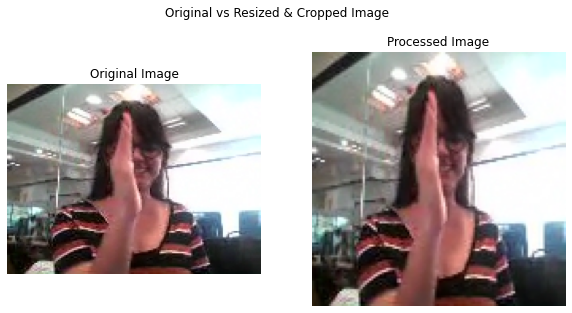

In [9]:
# View the images before and after pre-processing
 
from imageio import imread
import matplotlib.pyplot as plt
from PIL import Image
import random

# Function to resize and crop images
def resize_image(input_image, new_size):
    pil_image = Image.fromarray(input_image.astype(np.uint8))
    resized_image = pil_image.resize(new_size, Image.ANTIALIAS)
    return np.array(resized_image)

def display_images(original, processed, title="Original vs Processed"):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(title)
    axes[0].imshow(original)
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    
    axes[1].imshow(processed)
    axes[1].set_title("Processed Image")
    axes[1].axis('off')
    
    plt.show()

def display_random_resize_and_crop(source_path):
    # Randomly select a folder from the source path
    folders = [f for f in os.listdir(source_path) if os.path.isdir(os.path.join(source_path, f))]
    random_folder = random.choice(folders)
    folder_path = os.path.join(source_path, random_folder)
    
    # Randomly select 1 image from the chosen folder
    img_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    img_file = random.choice(img_files)
    
    # Load the original image
    img_path = os.path.join(folder_path, img_file)
    original_image = imread(img_path).astype(np.float32) / 255.0
    
    # Apply resize and crop
    crop_box = (0, 0, 120, 120)  # Example crop box, adjust as needed
    new_size = (120, 120)         # Example new size, adjust as needed
    processed_image = resize_image(original_image * 255.0, new_size) / 255.0
    
    # Display the original and processed images
    display_images(original_image, processed_image, title="Original vs Resized & Cropped Image")

# Example usage
display_random_resize_and_crop("/home/datasets/Project_data/train")

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [10]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

#### MODEL 13. Model 12+ L2 regularization

- batch size 32
- Time distributed(Conv2D)+ LSTM
- L2 regularization after every layer

In [11]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.layers import TimeDistributed, GRU, Dense, BatchNormalization, Dropout, Flatten, LSTM

classes = 5
time_steps = 30  # Number of time steps (e.g., number of frames in a video)
img_height = 120  # Height of each frame
img_width = 120   # Width of each frame
channels = 3      # Number of color channels (e.g., RGB)
l2_reg = 0.01     # L2 regularization factor

model = models.Sequential()

# Adding Conv2D layers with L2 regularization
model.add(TimeDistributed(layers.Conv2D(16, (3, 3), padding='same', activation='relu', 
                                        kernel_regularizer=regularizers.l2(l2_reg)), 
                          input_shape=(time_steps, img_height, img_width, channels)))             
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(layers.MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(layers.Conv2D(32, (3, 3), padding='same', activation='relu', 
                                        kernel_regularizer=regularizers.l2(l2_reg))))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(layers.MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(layers.Conv2D(64, (3, 3), padding='same', activation='relu', 
                                        kernel_regularizer=regularizers.l2(l2_reg))))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(layers.MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(layers.Conv2D(128, (3, 3), padding='same', activation='relu', 
                                        kernel_regularizer=regularizers.l2(l2_reg))))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(layers.MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(layers.Conv2D(256, (3, 3), padding='same', activation='relu', 
                                        kernel_regularizer=regularizers.l2(l2_reg))))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(layers.MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Flatten()))

# Adding LSTM with L2 regularization
model.add(LSTM(64, kernel_regularizer=regularizers.l2(l2_reg)))
model.add(Dropout(0.25))

# Adding Dense layers with L2 regularization
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)))
model.add(Dropout(0.25))
        
model.add(Dense(classes, activation='softmax', kernel_regularizer=regularizers.l2(l2_reg)))


2024-10-27 16:52:35.655296: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-10-27 16:52:35.655362: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3d:00.0, compute capability: 7.5


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [12]:
from tensorflow.keras.optimizers import Adam

optimiser = Adam(learning_rate=0.0002)  # Note: use 'learning_rate' instead of 'lr'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 60, 60, 32)   1

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [13]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)


In [14]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import os
from datetime import datetime

# Define current date and time for model naming
curr_dt_time = datetime.now()

# Create model directory name
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

# Create directory if it does not exist
if not os.path.exists(model_name):
    os.mkdir(model_name)

# Define filepath for saving the model
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

# ReduceLROnPlateau callback
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode="auto", min_delta=1e-04, cooldown=0, min_lr=0)

# List of callbacks
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

In [15]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [16]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/20


2024-10-27 16:52:42.678030: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 9.8576 - categorical_accuracy: 0.3771Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: val_loss improved from inf to 10.05705, saving model to model_init_2024-10-2716_52_36.061015/model-00001-9.85764-0.37707-10.05705-0.21000.h5
21/21 [==============================] - 96s 4s/step - loss: 9.8576 - categorical_accuracy: 0.3771 - val_loss: 10.0570 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 9.2983 - categorical_accuracy: 0.5370
Epoch 00002: val_loss improved from 10.05705 to 9.83028, saving model to model_init_2024-10-2716_52_36.061015/model-00002-9.29833-0.53695-9.83028-0.19000.h5
21/21 [==============================] - 93s 5s/step - loss: 9.2983 - categorical_accuracy: 0.5370 - val_loss: 9.8303 - val_categorical_accuracy: 0.1900 - lr: 2.0000e-04
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 8.8424 - categ

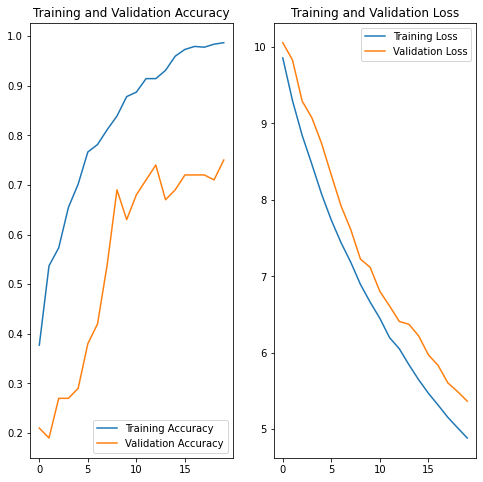

In [17]:
visualize_accuracy(history, num_epochs)